In [1]:
import yfinance as yf

def get_company_details(symbol):
    ticker = yf.Ticker(symbol)
    company_info = ticker.info
    return company_info

# Example usage
symbol = 'AAPL'  # Apple Inc.
all = get_company_details(symbol)

In [26]:
all

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. In addition, the company offers various services, such as Apple Arcade, a game subscriptio

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime

In [6]:
# Define the function to perform portfolio optimization
def portfolio_optimization(weights, log_returns, rf_rate):
    port_log_returns = np.sum(log_returns * weights, axis=1)
    port_mean_return = np.mean(port_log_returns)
    port_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov(), weights)))
    Sharpe_ratio = (port_mean_return - rf_rate) / port_volatility
    portfolio_return = (1 + port_mean_return) * (1 + rf_rate) - 1
    return np.array([port_mean_return, port_volatility, Sharpe_ratio, portfolio_return])

# Define the objective function for optimization
def objective_function(weights, log_returns, rf_rate):
    return portfolio_optimization(weights, log_returns, rf_rate)[0]

In [7]:
# Set the necessary input parameters
symbol_list = "TCS.NS, ITC.NS, RELIANCE.NS"
risk_free_rate = 0.035
portfolio_amount = 1000000
start_date = "2002-12-01"
end_date = datetime.date.today()
interval = "1wk"
max_allocation = 0.1

# Convert symbol list to ticker symbols
tickers = [symbol.strip() for symbol in symbol_list.split(",")]

# Download stock price data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Adj Close'].fillna(method='ffill')

[*********************100%***********************]  3 of 3 completed


In [8]:
# Calculate log returns for each stock
log_returns = np.log(data / data.shift(1)).dropna()

# User-defined Risk Free Rate and Maximum weight for each stock
rf_rate = float(risk_free_rate)
Max_allocation_p = float(max_allocation)

# Define bounds and constraints for optimization process
bounds = tuple((0, 1) for _ in range(len(tickers)))
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda x: Max_allocation_p - x})

In [9]:
# Perform cross-validation to choose the regression model
tscv = TimeSeriesSplit(n_splits=5)
regressor = LinearRegression()
mean_r_squared = []
for train_index, test_index in tscv.split(log_returns):
    train_log_returns, test_log_returns = log_returns.iloc[train_index], log_returns.iloc[test_index]
    train_X, train_y = train_log_returns.iloc[:, :-1], train_log_returns.iloc[:, -1]
    test_X, test_y = test_log_returns.iloc[:, :-1], test_log_returns.iloc[:, -1]
    regressor.fit(train_X, train_y)
    mean_r_squared.append(regressor.score(test_X, test_y))
mean_r_squared = np.mean(mean_r_squared)

# Perform portfolio optimization using the chosen regression model and maximizing Sharpe Ratio
weights = minimize(objective_function, len(tickers) * [1 / len(tickers)],
                   args=(log_returns, rf_rate), method='SLSQP', bounds=bounds, constraints=constraints).x
weights /= np.sum(weights)

# Print portfolio weights and performance metrics
portfolio = pd.DataFrame({'Ticker': tickers, 'Weight': weights})
port_mean_return, port_volatility, Sharpe_ratio, portfolio_return = portfolio_optimization(
    weights, log_returns, rf_rate)

portfolio_amount = float(portfolio_amount)
if not np.isnan(portfolio_amount):
    # Get discrete allocation of each share per stock
    allocation = np.multiply(weights, portfolio_amount)

    # Use vlookup to get latest prices
    latest_prices = pd.DataFrame({'Ticker': tickers})
    latest_prices['Latest Price'] = latest_prices['Ticker'].apply(lambda x: data[x].iloc[-1])

    # Divide allocation by latest prices
    latest_prices.set_index('Ticker', inplace=True)
    allocation_df = pd.DataFrame({'Ticker': tickers, 'Allocation': allocation})
    allocation_df.set_index('Ticker', inplace=True)
    allocation_df['Number of shares to buy'] = round(allocation_df['Allocation'] / latest_prices['Latest Price'], 0)
    allocation_df['Latest Price'] = round(latest_prices['Latest Price'], 4)
    allocation_df['Latest Value'] = round(allocation_df['Number of shares to buy'] * latest_prices['Latest Price'], 4)

    allocation_df.reset_index(inplace=True)

    # Create portfolio_df and print allocation for stocks with weight >= 1
    portfolio_df = allocation_df[['Ticker', 'Number of shares to buy', 'Latest Price', 'Latest Value']]
    high_allocation_df = portfolio_df[portfolio_df['Number of shares to buy'] >= 1]

    # Calculate remaining funds
    remaining_funds = portfolio_amount - np.dot(latest_prices['Latest Price'], allocation_df['Number of shares to buy'])

    # Generate pie chart
    labels = high_allocation_df['Ticker']
    values = high_allocation_df['Latest Value']
    fig = {
        "data": [dict(type="pie", labels=labels, values=values)],
        "layout": dict(title="Portfolio Allocation")
    }

    # Prepare portfolio information for display
    portfolio_info = pd.DataFrame({
        "Portfolio Allocation": ["Number of shares to buy with the amount of " + str(portfolio_amount),
                                 "Funds remaining:" + str(round(remaining_funds, 2)),
                                 "Volatility:" + str(round(port_volatility * 100, 2)) + "%",
                                 "Sharpe Ratio:" + str(round(Sharpe_ratio, 6)),
                                 "Portfolio Returns:" + str(round(portfolio_return * 100, 2)) + "%"]
    })

    print(portfolio_info)
    print(high_allocation_df)


                                Portfolio Allocation
0  Number of shares to buy with the amount of 100...
1                            Funds remaining:-428.61
2                                   Volatility:2.99%
3                             Sharpe Ratio:-1.040244
4                             Portfolio Returns:3.9%
        Ticker  Number of shares to buy  Latest Price  Latest Value
0       TCS.NS                    104.0     3197.3501   332524.4102
1       ITC.NS                    749.0      445.1000   333379.9046
2  RELIANCE.NS                    134.0     2496.4500   334524.2935


In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import datetime


# Define function to update portfolio
def update_portfolio(symbol_list, risk_free_rate, portfolio_amount, start_date, end_date, interval, max_allocation):
    # Convert symbol list to ticker symbols
    tickers = [symbol.strip() for symbol in symbol_list.split(",")]

    # Download stock price data from Yahoo Finance
    data = yf.download(tickers, start=start_date, end=end_date, interval=interval)['Adj Close'].fillna(method='ffill')

    # Calculate log returns for each stock
    log_returns = np.log(data / data.shift(1)).dropna()

    # User-defined Risk Free Rate and Maximum weight for each stock
    rf_rate = float(risk_free_rate)
    Max_allocation_p = float(max_allocation)

    # Create function to perform portfolio optimization using mean-variance optimization framework
    def portfolio_optimization(weights, log_returns, rf_rate):
        port_log_returns = np.sum(log_returns * weights, axis=1)
        port_mean_return = np.mean(port_log_returns)
        port_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov(), weights)))
        Sharpe_ratio = (port_mean_return - rf_rate) / port_volatility
        portfolio_return = (1 + port_mean_return) * (1 + rf_rate) - 1
        return np.array([port_mean_return, port_volatility, Sharpe_ratio, portfolio_return])

    # Define objective function for optimization process
    def objective_function(weights, log_returns, rf_rate):
        return portfolio_optimization(weights, log_returns, rf_rate)[0]

    # Define bounds and constraints for optimization process
    bounds = tuple((0, 1) for _ in range(len(tickers)))
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'ineq', 'fun': lambda x: Max_allocation_p - x})

    # Perform cross-validation to choose regression model
    tscv = TimeSeriesSplit(n_splits=5)
    regressor = LinearRegression()
    mean_r_squared = []
    for train_index, test_index in tscv.split(log_returns):
        train_log_returns, test_log_returns = log_returns.iloc[train_index], log_returns.iloc[test_index]
        train_X, train_y = train_log_returns.iloc[:, :-1], train_log_returns.iloc[:, -1]
        test_X, test_y = test_log_returns.iloc[:, :-1], test_log_returns.iloc[:, -1]
        regressor.fit(train_X, train_y)
        mean_r_squared.append(regressor.score(test_X, test_y))
    mean_r_squared = np.mean(mean_r_squared)

    # Perform portfolio optimization using the chosen regression model and maximizing Sharpe Ratio
    weights = minimize(objective_function, len(tickers) * [1 / len(tickers)],
                       args=(log_returns, rf_rate), method='SLSQP', bounds=bounds, constraints=constraints).x
    weights /= np.sum(weights)

    # Print portfolio weights and performance metrics
    portfolio = pd.DataFrame({'Ticker': tickers, 'Weight': weights})
    port_mean_return, port_volatility, Sharpe_ratio, portfolio_return = portfolio_optimization(
        weights, log_returns, rf_rate)

    portfolio_amount = float(portfolio_amount)
    if not np.isnan(portfolio_amount):
        # Get discrete allocation of each share per stock
        allocation = np.multiply(weights, portfolio_amount)

        # Use vlookup to get latest prices
        latest_prices = pd.DataFrame({'Ticker': tickers})
        latest_prices['Latest Price'] = latest_prices['Ticker'].apply(lambda x: data[x].iloc[-1])

        # Divide allocation by latest prices
        latest_prices.set_index('Ticker', inplace=True)
        allocation_df = pd.DataFrame({'Ticker': tickers, 'Allocation': allocation})
        allocation_df.set_index('Ticker', inplace=True)
        allocation_df['Number of shares to buy'] = round(allocation_df['Allocation'] / latest_prices['Latest Price'], 0)
        allocation_df['Latest Price'] = round(latest_prices['Latest Price'], 4)
        allocation_df['Latest Value'] = round(allocation_df['Number of shares to buy'] * latest_prices['Latest Price'], 4)

        allocation_df.reset_index(inplace=True)

        # Create portfolio_df and print allocation for stocks with weight >= 1
        portfolio_df = allocation_df[['Ticker', 'Number of shares to buy', 'Latest Price', 'Latest Value']]
        high_allocation_df = portfolio_df[portfolio_df['Number of shares to buy'] >= 1]

        # Calculate remaining funds
        remaining_funds = portfolio_amount - np.dot(latest_prices['Latest Price'], allocation_df['Number of shares to buy'])

        # Prepare portfolio information for display
        portfolio_info = {
            'Portfolio Allocation': {
                'Number of shares to buy with the amount of ₹': portfolio_amount,
                'Funds remaining: ₹': round(remaining_funds, 2),
                'Volatility: ': str(round(port_volatility * 100, 2)) + '%',
                'Sharpe Ratio: ': str(round(Sharpe_ratio, 6)),
                'Portfolio Returns: ': str(round(portfolio_return * 100, 2)) + '%'
            },
            'High Allocation Stocks': high_allocation_df.to_dict('records')
        }

        return {'Portfolio Allocation': {'Number of shares to buy with the amount of ₹': portfolio_amount,
                                 'Funds remaining: ₹': round(remaining_funds, 2),
                                 'Volatility: ': str(round(port_volatility * 100, 2)) + '%',
                                 'Sharpe Ratio: ': str(round(Sharpe_ratio, 6)),
                                 'Portfolio Returns: ': str(round(portfolio_return * 100, 2)) + '%'},
        'High Allocation Stocks': high_allocation_df.to_dict('records')}



# Example usage
symbol_list = "TCS.NS, ITC.NS, RELIANCE.NS"
risk_free_rate = 0.035
portfolio_amount = 1000000
start_date = "2002-12-01"
end_date = datetime.date.today()
interval = "1wk"
max_allocation = 0.1

portfolio_info = update_portfolio(symbol_list, risk_free_rate, portfolio_amount, start_date, end_date, interval, max_allocation)

# Print portfolio information
for key, value in portfolio_info.items():
    print(key)
    if isinstance(value, list):
        for item in value:
            for k, v in item.items():
                print(k, v)
    else:
        for k, v in value.items():
            print(k, v)
    print()



[*********************100%***********************]  3 of 3 completed
Portfolio Allocation
Number of shares to buy with the amount of ₹ 1000000.0
Funds remaining: ₹ -428.61
Volatility:  2.99%
Sharpe Ratio:  -1.040244
Portfolio Returns:  3.9%

High Allocation Stocks
Ticker TCS.NS
Number of shares to buy 104.0
Latest Price 3197.3501
Latest Value 332524.4102
Ticker ITC.NS
Number of shares to buy 749.0
Latest Price 445.1
Latest Value 333379.9046
Ticker RELIANCE.NS
Number of shares to buy 134.0
Latest Price 2496.45
Latest Value 334524.2935



In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import datetime

# Define portfolio allocation function
def optimize_portfolio(symbols, start_date, end_date, interval, portfolio_amount, risk_free_rate, max_allocation):
    # Download historical data
    data = yf.download(symbols, start=start_date, end=end_date, interval=interval)["Adj Close"]

    # Calculate returns
    returns = data.pct_change().dropna()

    # Prepare input data for linear regression
    X = np.arange(1, len(returns) + 1).reshape(-1, 1)
    y = returns.values

    # Fit linear regression model
    lr = LinearRegression()
    lr.fit(X, y)

    # Predict next day's return
    next_day = len(returns) + 1
    next_return = lr.predict([[next_day]])[0]

    # Optimize portfolio allocation
    def objective(weights):
        # Calculate portfolio returns and volatility
        portfolio_return = np.sum(returns.mean() * weights) * 252
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

        # Calculate Sharpe ratio
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

        # Minimize negative Sharpe ratio
        return -sharpe_ratio

    # Define constraints for portfolio allocation
    def constraints(weights):
        # Constraint: sum of weights should be 1
        return np.sum(weights) - 1

    # Define bounds for weights
    bounds = [(0, max_allocation) for _ in range(len(symbols))]

    # Set initial guess for weights
    initial_weights = np.ones(len(symbols)) / len(symbols)

    # Perform optimization
    result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints={'type': 'eq', 'fun': constraints})

    # Extract optimized weights
    optimized_weights = result.x

    # Calculate number of shares to buy
    prices = data.iloc[-1]
    shares_to_buy = (portfolio_amount * optimized_weights) / prices

    # Calculate remaining funds
    funds_remaining = portfolio_amount - np.dot(prices, shares_to_buy)

    # Calculate portfolio returns and volatility
    portfolio_returns = np.sum(returns.mean() * optimized_weights) * 252
    portfolio_volatility = np.sqrt(np.dot(optimized_weights.T, np.dot(returns.cov() * 252, optimized_weights)))

    # Calculate Sharpe ratio
    sharpe_ratio = (portfolio_returns - risk_free_rate) / portfolio_volatility

    # Print results
    print("Number of shares to buy with the amount of ₹", portfolio_amount)
    for symbol, shares in zip(symbols, shares_to_buy):
        print(symbol + ":", shares)
    print("Funds remaining: ₹", funds_remaining)
    print("Volatility: ", "{:.2%}".format(portfolio_volatility))
    print("Sharpe Ratio: ", sharpe_ratio)
    print("Portfolio Returns: ", "{:.2%}".format(portfolio_returns))

# Run the portfolio optimization
symbols = ["TCS.NS", "ITC.NS", "RELIANCE.NS"]
start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2021, 12, 31)
interval = "1d"
portfolio_amount = 100000.0
risk_free_rate = 0.035
max_allocation = 1.0

optimize_portfolio(symbols, start_date, end_date, interval, portfolio_amount, risk_free_rate, max_allocation)


[*********************100%***********************]  3 of 3 completed
Number of shares to buy with the amount of ₹ 100000.0
TCS.NS: 0.0
ITC.NS: 9.187676341462563
RELIANCE.NS: 21.877139960095644
Funds remaining: ₹ 0.0
Volatility:  27.32%
Sharpe Ratio:  1.0691464016580194
Portfolio Returns:  32.71%


In [10]:
import yfinance as yf
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define the stock symbol and time range for data retrieval
stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2022-01-01'

# Fetch historical stock data from Yahoo Finance using yfinance
stock_data = yf.download(stock_symbol, start=start_date, end=end_date, progress=False)

# Preprocess the data
stock_data.reset_index(inplace=True)
stock_data['Date'] = stock_data['Date'].dt.date

# Calculate the next year's return
stock_data['NextYearReturn'] = stock_data['Close'].pct_change(periods=252) * 100

# Drop missing values in the target variable
stock_data.dropna(subset=['NextYearReturn'], inplace=True)

# Define the features and target variable
features = ['Open', 'High', 'Low', 'Volume']
target = 'NextYearReturn'

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(stock_data[features], stock_data[target], test_size=0.2, random_state=42)

# Create and train the linear regression model
regression_model = LinearRegression()
regression_model.fit(train_data, train_labels)

# Make predictions on the testing set
predicted_labels = regression_model.predict(test_data)

# Evaluate the model
mse = mean_squared_error(test_labels, predicted_labels)
r2 = r2_score(test_labels, predicted_labels)

print('Mean Squared Error:', mse)
print('R-squared:', r2)

# Predict next year's return
future_data = stock_data.iloc[-251:, :].copy()
future_data['Date'] = pd.date_range(start=end_date, periods=252, closed='right').date
future_data = future_data[features]  # Keep only the features

future_predictions = regression_model.predict(future_data)

# Print the predicted next year's return
future_predictions_df = pd.DataFrame({'Date': future_data.index, 'Predicted Return': future_predictions})
print('Predicted Next Year Return:')
print(future_predictions_df)


Mean Squared Error: 335.2981896492879
R-squared: 0.4167620262085715
Predicted Next Year Return:
     Date  Predicted Return
0     254         66.845355
1     255         81.363551
2     256         70.007301
3     257         65.671123
4     258         68.803372
..    ...               ...
246   500         10.677395
247   501          8.821374
248   502          5.744682
249   503          4.912424
250   504          8.053748

[251 rows x 2 columns]


C:\Users\Richard Patrick\AppData\Local\Temp\ipykernel_22480\453027623.py:48: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_data['Date'] = pd.date_range(start=end_date, periods=252, closed='right').date


In [6]:
import yfinance as yf
import numpy as np
from skopt import Optimizer
from sklearn.svm import SVR

# Get historical stock data
tickers = ['AAPL', 'GOOGL', 'MSFT']  # Example tickers
data = yf.download(tickers, start='2019-01-01', end='2021-12-31')['Adj Close']

# Define the objective function for optimization
def portfolio_objective_function(weights, data):
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Calculate daily returns
    returns = data.pct_change().dropna()
    
    # Calculate portfolio returns
    portfolio_returns = np.dot(returns, weights)
    
    # Calculate portfolio metrics (e.g., return, risk, Sharpe ratio)
    portfolio_return = np.mean(portfolio_returns)
    portfolio_risk = np.std(portfolio_returns)
    sharpe_ratio = portfolio_return / portfolio_risk
    
    # Return negative Sharpe ratio as the objective (to maximize Sharpe ratio)
    return -sharpe_ratio

# Define the parameter space for optimization
param_space = [(0.0, 1.0)] * 3  # Example: 3 assets

# Perform Bayesian optimization
optimizer = Optimizer(param_space, "GP", acq_optimizer="sampling")
best_sharpe_ratio = float("-inf")
best_weights = None

for _ in range(10):  # Number of iterations
    suggested = optimizer.ask()
    loss = portfolio_objective_function(suggested, data)
    optimizer.tell(suggested, loss)
    
    if loss > best_sharpe_ratio:
        best_sharpe_ratio = loss
        best_weights = suggested / np.sum(suggested)

# Print the best parameter values and corresponding Sharpe ratio
print("Best Sharpe Ratio:", best_sharpe_ratio)
print("Best Allocation Weights:", best_weights)


[*********************100%***********************]  3 of 3 completed
Best Sharpe Ratio: -0.09267837808480546
Best Allocation Weights: [0.07929886 0.69513481 0.22556633]


In [53]:
import yfinance as yf
import numpy as np
from pypfopt import expected_returns, risk_models
from pypfopt.efficient_frontier import EfficientFrontier
from bayes_opt import BayesianOptimization
import pandas as pd

# Define the objective function for optimization
def optimize_portfolio(**weights):
    # Extract the weights
    weights = np.array(list(weights.values()))
    
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Calculate expected returns and covariance matrix
    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)
    
    # Create the Efficient Frontier object
    ef = EfficientFrontier(mu, S)
    ef.min_volatility()
    
    # Calculate the portfolio performance metrics
    portfolio_return, portfolio_volatility, _ = ef.portfolio_performance()
    
    # Return the negative Sharpe ratio as the objective to be maximized
    return -portfolio_return / portfolio_volatility


data = pd.read_csv('Data/Stock_History/closing.csv')
data = data.drop('Date',axis=1)
data = data.dropna(axis='columns')
tickers=data.columns.tolist()

# Define the search space for the weights
search_space = {
    f'weight_{ticker}': (0, 1) for ticker in tickers
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=optimize_portfolio, pbounds=search_space, verbose=0)  # Set verbose=0 to hide iteration output
optimizer.maximize(init_points=10, n_iter=5)

# Get the optimized weights
optimal_weights = [optimizer.max['params'][f'weight_{ticker}'] for ticker in tickers]
optimal_weights /= np.sum(optimal_weights)
print('Optimized Weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")


Optimized Weights:
A: 0.0006
AAL: 0.0013
AAP: 0.0040
AAPL: 0.0006
ABBV: 0.0027
ABC: 0.0015
ABT: 0.0033
ACGL: 0.0022
ACN: 0.0038
ADBE: 0.0024
ADI: 0.0034
ADM: 0.0029
ADP: 0.0010
ADSK: 0.0034
AEE: 0.0033
AEP: 0.0023
AES: 0.0035
AFL: 0.0018
AIG: 0.0008
AIZ: 0.0003
AJG: 0.0005
AKAM: 0.0003
ALB: 0.0040
ALGN: 0.0009
ALK: 0.0036
ALL: 0.0034
ALLE: 0.0024
AMAT: 0.0012
AMCR: 0.0006
AMD: 0.0029
AME: 0.0012
AMGN: 0.0010
AMP: 0.0002
AMT: 0.0025
AMZN: 0.0008
ANET: 0.0002
ANSS: 0.0033
AON: 0.0001
AOS: 0.0039
APA: 0.0023
APD: 0.0007
APH: 0.0007
APTV: 0.0022
ARE: 0.0039
ATO: 0.0004
ATVI: 0.0016
AVB: 0.0015
AVGO: 0.0012
AVY: 0.0033
AWK: 0.0017
AXON: 0.0035
AXP: 0.0003
AZO: 0.0009
BA: 0.0038
BAC: 0.0028
BALL: 0.0012
BAX: 0.0011
BBWI: 0.0017
BBY: 0.0006
BDX: 0.0036
BEN: 0.0020
BF-B: 0.0029
BG: 0.0009
BIIB: 0.0019
BIO: 0.0026
BK: 0.0022
BKNG: 0.0016
BKR: 0.0004
BLK: 0.0007
BMY: 0.0038
BR: 0.0005
BRK-B: 0.0011
BRO: 0.0024
BSX: 0.0034
BWA: 0.0030
BXP: 0.0032
C: 0.0039
CAG: 0.0022
CAH: 0.0019
CAT: 0.0041
CB: 

In [2]:
import yfinance as yf
import numpy as np
from pypfopt import expected_returns, risk_models, DiscreteAllocation
from pypfopt.efficient_frontier import EfficientFrontier
from bayes_opt import BayesianOptimization
import pandas as pd

# Define the objective function for optimization
def optimize_portfolio(**weights):
    # Extract the weights
    weights = np.array(list(weights.values()))
    
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Calculate expected returns and covariance matrix
    mu = expected_returns.mean_historical_return(data)
    S = risk_models.sample_cov(data)
    
    # Create the Efficient Frontier object
    ef = EfficientFrontier(mu, S)
    
    # Set the portfolio weights
    ef.weights = weights
    
    # Calculate the portfolio performance metrics
    portfolio_return, portfolio_volatility, _ = ef.portfolio_performance()
    
    # Return the negative Sharpe ratio as the objective to be maximized
    return -portfolio_return / portfolio_volatility


data = pd.read_csv('Data/Stock_History/closing.csv')
data = data.drop('Date',axis=1)
data = data.dropna(axis='columns')
tickers=data.columns.tolist()


# Define the search space for the weights
search_space = {
    f'weight_{ticker}': (0, 1) for ticker in tickers
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=optimize_portfolio, pbounds=search_space, verbose=0)  # Set verbose=0 to hide iteration output
optimizer.maximize(init_points=10, n_iter=50)

# Get the optimized weights
optimal_weights = [optimizer.max['params'][f'weight_{ticker}'] for ticker in tickers]
optimal_weights /= np.sum(optimal_weights)
print('Optimized Weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

# Create a portfolio using the optimized weights
latest_prices = data.iloc[-1]
da = DiscreteAllocation(weights=dict(zip(tickers, optimal_weights)), latest_prices=latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print('\nPortfolio Allocation:')
for ticker, shares in allocation.items():
    print(f"{ticker}: {shares} shares")

print(f"\nRemaining Cash: ${leftover:.2f}")


Optimized Weights:
A: 0.0031
AAL: 0.0022
AAP: 0.0035
AAPL: 0.0027
ABBV: 0.0031
ABC: 0.0016
ABT: 0.0019
ACGL: 0.0008
ACN: 0.0013
ADBE: 0.0026
ADI: 0.0020
ADM: 0.0029
ADP: 0.0034
ADSK: 0.0014
AEE: 0.0022
AEP: 0.0036
AES: 0.0008
AFL: 0.0017
AIG: 0.0027
AIZ: 0.0019
AJG: 0.0039
AKAM: 0.0025
ALB: 0.0021
ALGN: 0.0029
ALK: 0.0024
ALL: 0.0038
ALLE: 0.0021
AMAT: 0.0027
AMCR: 0.0029
AMD: 0.0031
AME: 0.0012
AMGN: 0.0021
AMP: 0.0000
AMT: 0.0019
AMZN: 0.0022
ANET: 0.0036
ANSS: 0.0029
AON: 0.0012
AOS: 0.0018
APA: 0.0020
APD: 0.0007
APH: 0.0006
APTV: 0.0012
ARE: 0.0034
ATO: 0.0009
ATVI: 0.0002
AVB: 0.0023
AVGO: 0.0039
AVY: 0.0004
AWK: 0.0035
AXON: 0.0003
AXP: 0.0026
AZO: 0.0008
BA: 0.0038
BAC: 0.0009
BALL: 0.0031
BAX: 0.0028
BBWI: 0.0022
BBY: 0.0022
BDX: 0.0022
BEN: 0.0026
BF-B: 0.0005
BG: 0.0006
BIIB: 0.0016
BIO: 0.0038
BK: 0.0030
BKNG: 0.0020
BKR: 0.0038
BLK: 0.0016
BMY: 0.0006
BR: 0.0029
BRK-B: 0.0027
BRO: 0.0006
BSX: 0.0041
BWA: 0.0015
BXP: 0.0012
C: 0.0008
CAG: 0.0009
CAH: 0.0005
CAT: 0.0015
CB: 

f:\anaconda\envs\Project\lib\site-packages\cvxpy\problems\problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [2]:
import yfinance as yf
import numpy as np
from pypfopt import expected_returns, risk_models, DiscreteAllocation
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from bayes_opt import BayesianOptimization
import pandas as pd

# Define the objective function for optimization
def optimize_portfolio(**weights):

    # Extract the weights
    weights = np.array(list(weights.values()))
    
    # Normalize weights
    weights = weights / np.sum(weights)
    
    # Calculate expected returns and covariance matrix
    mu = expected_returns.mean_historical_return(data)
    S = CovarianceShrinkage(data).ledoit_wolf()
    
    # Create the Efficient Frontier object
    ef = EfficientFrontier(mu, S)
    
    # Set the portfolio weights
    ef.weights = weights
    
    # Calculate the portfolio performance metrics
    portfolio_return, portfolio_volatility, _ = ef.portfolio_performance()
    
    # Return the negative Sharpe ratio as the objective to be maximized
    return -portfolio_return / portfolio_volatility


data = pd.read_csv('Data/Stock_History/closing.csv')
data = data.drop('Date',axis=1)
data = data.dropna(axis='columns')
tickers=data.columns.tolist()


# Define the search space for the weights
search_space = {
    f'weight_{ticker}': (0, 1) for ticker in tickers
}

# Perform Bayesian optimization
optimizer = BayesianOptimization(f=optimize_portfolio, pbounds=search_space, verbose=1)  # Set verbose=0 to hide iteration output
optimizer.maximize(init_points=10, n_iter=3)

# Get the optimized weights
optimal_weights = [optimizer.max['params'][f'weight_{ticker}'] for ticker in tickers]
optimal_weights /= np.sum(optimal_weights)
print('Optimized Weights:')
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")


|   iter    |  target   | weight_A  | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight_BA | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight... | weight_BG | weight... | weight... | weight_BK | weight... | weight... | weight... | weight... | weight_BR | weight... | weight... | weight... | weight... | weight... | weight_C  | weight... | weight... | weight... | weight_CB | we

In [3]:
# Create a portfolio using the optimized weights
latest_prices = data.iloc[-1]
da = DiscreteAllocation(weights=dict(zip(tickers, optimal_weights)), latest_prices=latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print('\nPortfolio Allocation:')
for ticker, shares in allocation.items():
    print(f"{ticker}: {shares} shares")

print(f"\nRemaining Cash: ${leftover:.2f}")




Portfolio Allocation:
CRM: 1 shares
IP: 1 shares
JNPR: 1 shares
CFG: 1 shares
DD: 1 shares
IVZ: 2 shares
ZBH: 1 shares
NI: 1 shares
TT: 1 shares
FTNT: 1 shares
EL: 1 shares
STT: 1 shares
DGX: 1 shares
PAYX: 1 shares
SLB: 1 shares
PLD: 1 shares
HST: 2 shares
PODD: 1 shares
PG: 1 shares
AMD: 1 shares
ES: 1 shares
RTX: 1 shares
TPR: 1 shares
CVS: 1 shares
MGM: 1 shares
CSX: 1 shares
SWKS: 1 shares
LKQ: 1 shares
LRCX: 1 shares
MTB: 1 shares
AXON: 1 shares
WDC: 1 shares
UAL: 1 shares
HIG: 1 shares
SCHW: 1 shares
CPB: 1 shares
CNP: 1 shares
NDAQ: 1 shares
BR: 1 shares
FMC: 1 shares
MOH: 1 shares
DXC: 1 shares
HOLX: 1 shares
ZTS: 1 shares
FFIV: 1 shares
CTRA: 1 shares
VRTX: 1 shares
XRAY: 1 shares
JPM: 1 shares
ALL: 1 shares
MU: 1 shares
CDW: 1 shares
FISV: 1 shares
DLR: 1 shares
WRK: 1 shares
FLT: 1 shares
ARE: 1 shares
APTV: 1 shares
SNPS: 1 shares
TMO: 1 shares
T: 1 shares
TEL: 1 shares
IEX: 1 shares
PGR: 1 shares
ADI: 1 shares
RHI: 1 shares
PPG: 1 shares
MTCH: 1 shares
PNC: 1 shares
PEG:

[*********************100%***********************]  1 of 1 completed


12:12:32 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing


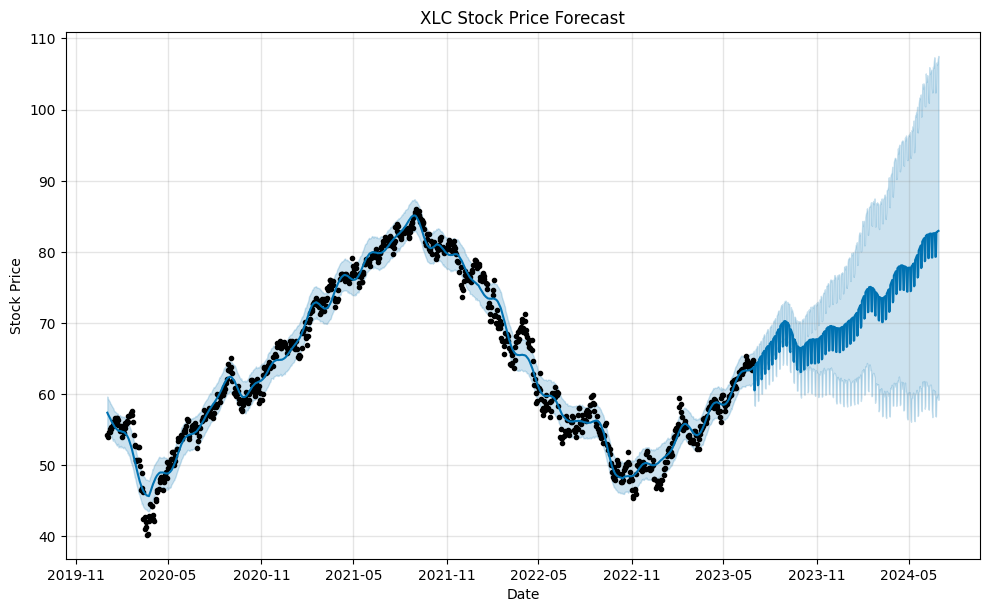

Next year's estimated returns: 18.25%


In [7]:
import yfinance as yf
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Define the stock symbol and date range
stock_symbol = 'XLC'
start_date = '2020-01-01'
end_date = '2023-06-30'

# Fetch historical stock price data using yfinance
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Reset the index and keep only 'Date' and 'Close' columns
data.reset_index(inplace=True)
data = data[['Date', 'Close']]
data.columns = ['ds', 'y']

# Create and fit the Prophet model
model = Prophet()
model.fit(data)

# Generate future dates
future_dates = model.make_future_dataframe(periods=365)

# Make predictions
forecast = model.predict(future_dates)

# Extract the relevant columns from the forecast
forecast_subset = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Filter the forecast for next year's data
next_year_forecast = forecast_subset[forecast_subset['ds'].dt.year == forecast_subset['ds'].dt.year.max()]

# Calculate the percentage change in stock prices
start_price = next_year_forecast.iloc[0]['yhat']
end_price = next_year_forecast.iloc[-1]['yhat']
returns = (end_price - start_price) / start_price * 100

# Plot the forecast
model.plot(forecast, xlabel='Date', ylabel='Stock Price')
plt.title('XLC Stock Price Forecast')
plt.show()

print("Next year's estimated returns: {:.2f}%".format(returns))


In [2]:
import numpy as np
import yfinance as yf

# Define the Firefly Algorithm

def firefly_algorithm(obj_func, dim, fireflies_count, iterations, lower_bound, upper_bound):
    # Initialization
    alpha = 0.2  # Firefly attractiveness
    beta = 1.0  # Light absorption coefficient
    gamma = 0.1  # Randomization parameter

    # Generate initial population
    population = np.random.uniform(lower_bound, upper_bound, (fireflies_count, dim))

    for _ in range(iterations):
        # Evaluate objective function for each firefly
        fitness = np.array([obj_func(firefly) for firefly in population])

        # Sort fireflies by fitness (minimization problem)
        sorted_indices = np.argsort(fitness)
        population = population[sorted_indices]

        # Update fireflies' positions
        for i in range(fireflies_count):
            for j in range(fireflies_count):
                if fitness[i] > fitness[j]:
                    distance = np.linalg.norm(population[i] - population[j])
                    attractiveness = alpha / (1 + beta * distance ** 2)
                    population[i] = (1 - attractiveness) * population[i] + attractiveness * population[j]
                    population[i] += gamma * np.random.uniform(lower_bound, upper_bound, dim)

    # Return the best firefly (portfolio)
    best_firefly = population[0]
    return best_firefly


# Define the objective function (portfolio performance metric)
def portfolio_objective(weights, data):
    # Calculate portfolio returns
    returns = data.pct_change().dropna()

    # Calculate portfolio performance metric (e.g., Sharpe ratio)
    port_returns = np.dot(returns, weights)
    port_mean_return = np.mean(port_returns)
    port_std_dev = np.std(port_returns)
    sharpe_ratio = port_mean_return / port_std_dev

    return -sharpe_ratio  # Minimize negative Sharpe ratio


# Set up portfolio optimization parameters
dimension = 4  # Number of assets in the portfolio
num_fireflies = 20
num_iterations = 100
lower_bound = 0.0
upper_bound = 1.0

# Fetch historical data for portfolio assets
tickers = ["AAPL", "GOOGL", "MSFT", "AMZN"]
data = yf.download(tickers, period="1y")["Adj Close"]

# Run Firefly Algorithm for portfolio optimization
best_portfolio = firefly_algorithm(lambda w: portfolio_objective(w, data), dimension, num_fireflies, num_iterations, lower_bound, upper_bound)

# Print optimal portfolio weights
print("Optimal Portfolio Weights:")
for i, ticker in enumerate(tickers):
    print(f"{ticker}: {best_portfolio[i]}")


[*********************100%***********************]  4 of 4 completed
Optimal Portfolio Weights:
AAPL: 0.9418267216813722
GOOGL: 0.4537358242555108
MSFT: 0.22157650892593914
AMZN: 0.33595800434915263


In [19]:
import pandas as pd
import yfinance as yf
from sklearn.ensemble import IsolationForest
from numpy import percentile

# Download stock data 
tickers = ['AAPL','AMZN','GOOG','META','NFLX']
data = yf.download(tickers,start='2017-01-01',end='2022-12-31')['Adj Close']

# Calculate returns
returns = data.pct_change()
returns = returns.dropna()

# Isolation forest model
iforest = IsolationForest(n_estimators=100, contamination='auto') 
iforest.fit(returns)

# Get anomaly scores
scores = iforest.decision_function(returns)
threshold = percentile(scores, 5)

# Get anomalous timestamps
integer_indices = returns.index.astype(int)
# Get timestamp indices  
# Anomaly timestamps
anomalies = returns.index[scores < threshold] 

# Convert to int64
int64_indices = anomalies.astype('int64')

# Convert int64 to int 
anomaly_indices = int64_indices.astype(int)

# Use indices to index tickers
high_risk_stocks = [tickers[i] for i in anomaly_indices]

print(high_risk_stocks)

[*********************100%***********************]  5 of 5 completed


TypeError: Converting from datetime64[ns] to int32 is not supported. Do obj.astype('int64').astype(dtype) instead